In [1]:
! pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.9 MB/s eta 0:00:00


In [2]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
# Material parameters for linear elasticity
lmbd = 1.0  # First Lamé parameter
mu = 0.5    # Second Lamé parameter (shear modulus)
gravity = 9.8  # Gravity magnitude applied in the negative Y direction
mass = 1.5
# Define geometry for a 3D beam (length=4, width=1, height=1)
geom = dde.geometry.Cuboid([0, 0, 0], [4, 1, 1])

In [ ]:
# Boundary condition functions
def boundary_fixed(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)

def boundary_free(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 4.0)

# Fixed boundary at one end (ux=0, uy=0, uz=0)
bc_fixed_x = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=0)  # ux=0
bc_fixed_y = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=1)  # uy=0
bc_fixed_z = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=2)  # uz=0

import numpy as np

# Gravity force increasing step by step in the x-direction
def gravity_force(inputs, outputs, X):
    # Initialize force arrays
    force_x = -mass * np.ones_like(X[:, 0])  # pour se plier
    force_y = -gravity * np.ones_like(X[:, 1])  # Initial gravity in the negative y direction
    force_z = np.zeros_like(X[:, 2])  # No force in the z direction

    return np.stack([force_x, force_y, force_z], axis=1)


bc_gravity = dde.icbc.OperatorBC(geom, gravity_force, lambda x, _: True)  # Applies to all points

# Define the boundary conditions list
bc = [bc_fixed_x, bc_fixed_y, bc_fixed_z, bc_gravity]


In [5]:
# Define PDE for 3D linear elasticity
def pde(X, u):
    ux, uy, uz = u[:, 0:1], u[:, 1:2], u[:, 2:3]

    # Strain components
    E_xx = dde.grad.jacobian(ux, X, j=0)  # d(ux)/dx
    E_yy = dde.grad.jacobian(uy, X, j=1)  # d(uy)/dy
    E_zz = dde.grad.jacobian(uz, X, j=2)  # d(uz)/dz

    # Shear strain components
    E_xy = 0.5 * (dde.grad.jacobian(ux, X, j=1) + dde.grad.jacobian(uy, X, j=0))
    E_xz = 0.5 * (dde.grad.jacobian(ux, X, j=2) + dde.grad.jacobian(uz, X, j=0))
    E_yz = 0.5 * (dde.grad.jacobian(uy, X, j=2) + dde.grad.jacobian(uz, X, j=1))

    # Stress components based on strain and material properties
    Sxx = E_xx * (2 * mu + lmbd) + (E_yy + E_zz) * lmbd
    Syy = E_yy * (2 * mu + lmbd) + (E_xx + E_zz) * lmbd
    Szz = E_zz * (2 * mu + lmbd) + (E_xx + E_yy) * lmbd
    Sxy = 2 * mu * E_xy
    Sxz = 2 * mu * E_xz
    Syz = 2 * mu * E_yz

    # Elasticity equilibrium equations
    eq_x = dde.grad.jacobian(Sxx, X, j=0) + dde.grad.jacobian(Sxy, X, j=1) + dde.grad.jacobian(Sxz, X, j=2)
    eq_y = dde.grad.jacobian(Sxy, X, j=0) + dde.grad.jacobian(Syy, X, j=1) + dde.grad.jacobian(Syz, X, j=2)
    eq_z = dde.grad.jacobian(Sxz, X, j=0) + dde.grad.jacobian(Syz, X, j=1) + dde.grad.jacobian(Szz, X, j=2)

    return [eq_x, eq_y, eq_z]


In [4]:
# Visualization function to show the displacement
def plot_displacement(model):
    # Create a grid of points in the beam
    x = np.linspace(0, 4, 40)
    y = np.linspace(0, 1, 10)
    z = np.linspace(0, 1, 10)
    X, Y, Z = np.meshgrid(x, y, z)
    points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    # Predict displacements
    u_pred = model.predict(points)[:, :3]

    # Plotting predicted displacement
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.quiver(points[:, 0], points[:, 1], points[:, 2],
              u_pred[:, 0], u_pred[:, 1], u_pred[:, 2], color="blue")
    ax.set_title("Predicted Displacement Field (Blue)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

In [3]:

# Material parameters for linear elasticity
lmbd = 1.0  # First Lamé parameter
mu = 0.5    # Second Lamé parameter (shear modulus)
gravity = 9.8  # Gravity magnitude applied in the negative Y direction
mass = 10.5

# Define geometry for a 3D beam (length=4, width=1, height=1)
geom = dde.geometry.Cuboid([0, 0, 0], [4, 1, 1])

# Boundary condition functions
def boundary_fixed(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)

# Fixed boundary at one end (ux=0, uy=0, uz=0)
bc_fixed_x = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=0)  # ux=0
bc_fixed_y = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=1)  # uy=0
bc_fixed_z = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=2)  # uz=0

# Gravity force increasing in the y-direction
def gravity_force(inputs, outputs, X):
    force_x = np.zeros_like(X[:, 0])  # No force in x-direction
    force_y = -gravity * mass * np.ones_like(X[:, 1])  # Gravity in the negative y-direction
    force_z = np.zeros_like(X[:, 2])  # No force in z-direction
    return np.stack([force_x, force_y, force_z], axis=1)

bc_gravity = dde.icbc.OperatorBC(geom, gravity_force, lambda x, _: True)  # Applies to all points

# Define the boundary conditions list
bc = [bc_fixed_x, bc_fixed_y, bc_fixed_z, bc_gravity]


In [6]:

# Define the model
data = dde.data.PDE(geom, pde, bc, num_domain=4000, num_boundary=1000)
net = dde.maps.FNN([3] + [50] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=1e-4)
model.train(epochs=10000)


Compiling model...
Building feed-forward neural network...
'build' took 0.124429 s

'compile' took 6.128723 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.91e-01, 8.23e-03, 1.92e-02, 3.01e-02, 1.07e-02, 4.01e-02, 3.53e+03]    [1.91e-01, 8.23e-03, 1.92e-02, 3.01e-02, 1.07e-02, 4.01e-02, 3.53e+03]    []  
1000      [3.77e-05, 4.60e-05, 3.97e-05, 7.60e-06, 2.53e-06, 1.07e-06, 3.53e+03]    [3.77e-05, 4.60e-05, 3.97e-05, 7.60e-06, 2.53e-06, 1.07e-06, 3.53e+03]    []  
2000      [1.95e-05, 2.14e-05, 1.40e-05, 3.84e-06, 1.16e-06, 8.90e-07, 3.53e+03]    [1.95e-05, 2.14e-05, 1.40e-05, 3.84e-06, 1.16e-06, 8.90e-07, 3.53e+03]    []  
3000      [1.08e-05, 9.93e-06, 6.06e-06, 2.18e-06, 3.44e-07, 9.33e-07, 3.53e+03]    [1.08e-05, 9.93e-06, 6.06e-06, 2.18e-06, 3.44e-07, 9.33e-07, 3.53e+03]    []  
4000      [5.79e-06, 4.34e-06, 2.94e-06, 1.30e-0

(<deepxde.model.LossHistory at 0x7ca57fd6a260>,
 <deepxde.model.TrainState at 0x7ca4f5638430>)

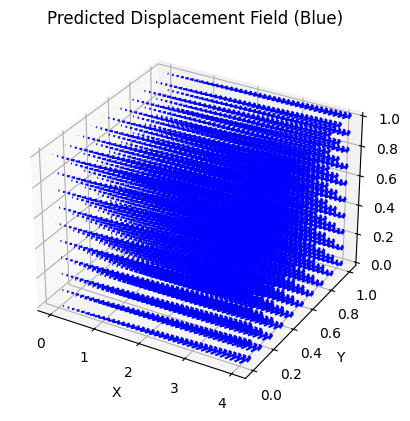

In [8]:
# Call the plotting function
plot_displacement(model)

In [7]:
import numpy as np
import plotly.graph_objects as go

def plot_displacement_plotly(model):
    # Create a grid of points in the beam
    x = np.linspace(0, 4, 40)
    y = np.linspace(0, 1, 10)
    z = np.linspace(0, 1, 10)
    X, Y, Z = np.meshgrid(x, y, z)
    points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    # Predict displacements
    u_pred = model.predict(points)[:, :3]
    displaced_points = points + u_pred

    # Create Scatter3d for the original grid points
    scatter_original = go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(size=2, color='blue'),
        name='Original Points'
    )

    # Create Scatter3d for the displaced grid points
    scatter_displaced = go.Scatter3d(
        x=displaced_points[:, 0],
        y=displaced_points[:, 1],
        z=displaced_points[:, 2],
        mode='markers',
        marker=dict(size=2, color='red'),
        name='Displaced Points'
    )

    # Configure the layout
    layout = go.Layout(
        title='3D Predicted Displacement Field',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        legend=dict(x=0.7, y=0.95)
    )

    # Create the figure and add Scatter3d traces
    fig = go.Figure(data=[scatter_original, scatter_displaced], layout=layout)
    fig.show()

# Call the plotting function
plot_displacement_plotly(model)


#Beam Configuration
Beam Orientation: The beam is horizontal, and its weight generates a load acting vertically downward due to gravity (g).\
Support Condition: One side is fixed (cantilever beam).\
Material: The beam’s material defines its density (𝜌) and modulus of elasticity (E).\
Cross-section: The geometry defines the second moment of inertia (I).

#Load Due to Gravity
The self-weight of the beam is treated as a uniformly distributed load (UDL),
q, given by: q=ρAg\
Where:\
ρ: Density of the beam material.\
A: Cross-sectional area of the beam.\
g: Gravitational acceleration (9.81 m/s).\

#Deflection Due to Self-Weight
The maximum deflection occurs at the free end of the cantilever beam. The formula for deflection due to a UDL is:\
$𝛿 =5𝑞𝐿^4 / 384𝐸𝐼 $\
Where:\
q: Uniformly distributed load (self-weight per unit length).\
L: Length of the beam.\
E: Elastic modulus.\
I: Moment of inertia of the cross-section\

#Steps to Calculate Horizontal Deformation
Step 1: Compute q Use: q=ρAg \
For example, if the beam is made of steel (𝜌≈7850kg/m) and has a rectangular cross-section with dimensions b and h, then: A=b⋅h\
Step 2: Find Moment of Inertia (I) For a rectangular cross-section:I= 12bh3\
Step 3: Plug Values into the Deflection Formula
Substitute all known values (q,L,E,I) into the deflection formula to find δ.

# Problem Formulation
The governing equation for the cantilever beam deformation under its self-weight is:
$EI \frac{d^4 w(x)}{dx^4} = q$\
Where:\
q=ρAg (uniform load due to gravity).
#Boundary conditions:
w(0)=0 (no deflection at the fixed end).\
w ′(0)=0 (no slope at the fixed end).\
w ′′(L)=0 (no moment at the free end).\
w ′′′(L)=0 (no shear at the free end).\